In [37]:
import pandas as pd
import lightgbm as lgb
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time

from matplotlib import gridspec

warnings.filterwarnings(action='ignore')

In [38]:
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Malgun Gothic'

In [18]:
movieData = pd.read_excel("df3.xlsx")
movieData

,영화명,개봉일,매출액,관객수,스크린수,상영횟수,대표국적,국적,배급사,연령등급,장르,러닝타임,감독,개봉월,계절
0,800,2020-12-10,135367500,15549,223,3738,중국,중국,TCO(주)더콘텐츠온,15세 관람가,전쟁,149,관후,12,겨울
1,1917,2020-02-19,7924722960,877017,932,91511,미국,미국,(주)스마일이엔티,15세 관람가,드라마,119,샘 멘데스,2,겨울
2,1987,2017-12-27,58169776145,1942077,1299,27619,한국,한국,(주)씨제이이엔엠,15세 관람가,드라마,129,장준환,12,겨울
3,#살아있다,2020-06-24,15968219900,1903992,1882,137073,한국,한국,롯데컬처웍스(주)롯데엔터테인먼트,15세 관람가,드라마,98,조일형,6,여름
4,0.0MHz,2019-05-29,1088258860,137294,446,5998,한국,한국,(주)스마일이엔티,15세 관람가,공포,102,유선동,5,봄
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2088,히트,2011-10-13,783919500,110631,171,5960,한국,한국,(주)넥스트엔터테인먼트월드(NEW),청소년 관람불가,범죄,170,마이클 만,10,가을
2089,히트맨,2007-11-29,1094879000,163414,155,10301,미국,미국,이십세기폭스필름코퍼레이션,청소년 관람불가,액션,92,자비에르 젠스,11,가을
2090,히트맨,2020-01-22,20614278000,2406232,1122,87782,한국,한국,롯데컬처웍스(주)롯데엔터테인먼트,15세 관람가,코미디,110,최원섭,1,겨울
2091,히트맨: 에이전트 47,2015-09-03,502308500,64157,272,4501,미국,미국,이십세기폭스코리아(주),15세 관람가,액션,98,알렉산더 바흐,9,가을


In [3]:
movieData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2093 entries, 0 to 2092
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   영화명     2093 non-null   object        
 1   개봉일     2093 non-null   datetime64[ns]
 2   매출액     2093 non-null   int64         
 3   관객수     2093 non-null   int64         
 4   스크린수    2093 non-null   int64         
 5   상영횟수    2093 non-null   int64         
 6   대표국적    2093 non-null   object        
 7   국적      2093 non-null   object        
 8   배급사     2093 non-null   object        
 9   연령등급    2093 non-null   object        
 10  장르      2093 non-null   object        
 11  러닝타임    2093 non-null   int64         
 12  감독      2093 non-null   object        
 13  개봉월     2093 non-null   int64         
 14  계절      2093 non-null   object        
dtypes: datetime64[ns](1), int64(6), object(8)
memory usage: 245.4+ KB


In [19]:
movieData.loc[movieData['장르']=='서사', '장르'] = '드라마'

In [20]:
movieData.loc[movieData['장르']=='블랙코미디', '장르'] = '코미디'

In [21]:
movieData['장르'].unique()

array(['전쟁', '드라마', '공포', '액션', '모험', '코미디', 'SF', '범죄', '멜로/로맨스', '스릴러',
       '판타지', '애니메이션', '미스터리', '다큐멘터리', '서스펜스', '가족', '공연실황', '뮤지컬',
       '대한민국', '느와르'], dtype=object)

In [22]:
movieData[movieData['장르'] == '대한민국']

,영화명,개봉일,매출액,관객수,스크린수,상영횟수,대표국적,국적,배급사,연령등급,장르,러닝타임,감독,개봉월,계절
737,명당,2018-09-19,17900775524,2087474,1117,58450,한국,한국,플러스엠 엔터테인먼트,12세 관람가,대한민국,126,박희곤,9,가을
902,번 더 스테이지: 더 무비,2018-11-15,2671391900,315010,243,4714,한국,한국,월트디즈니컴퍼니코리아 유한책임회사,전체 관람가,대한민국,83,박준수,11,가을
1137,스위치,2010-12-01,558483500,82503,162,6854,미국,미국,씨너스엔터테인먼트(주),12세 관람가,대한민국,113,마대윤,12,겨울
1697,천문: 하늘에 묻는다,2019-12-26,16503491020,2000648,2127,68980,한국,한국,롯데컬처웍스(주)롯데엔터테인먼트,12세 관람가,대한민국,132,허진호,12,겨울


In [23]:
movieData.loc[737, '장르'] = '시대극'
movieData.loc[902, '장르'] = '다큐멘터리'
movieData.loc[1137, '장르'] = '코미디'
movieData.loc[1697, '장르'] = '시대극'

In [24]:
movieData.loc[movieData['장르']=='서스펜스', '장르'] = '스릴러'

In [26]:
movieData.loc[movieData['장르']=='시대극', '장르'] = '드라마'

In [27]:
movieData['장르'].value_counts()

액션        444
드라마       347
애니메이션     346
코미디       207
범죄        126
공포        117
멜로/로맨스    114
스릴러        86
SF         67
판타지        63
모험         59
미스터리       45
전쟁         17
다큐멘터리      14
가족         14
공연실황       13
뮤지컬        10
느와르         4
Name: 장르, dtype: int64

In [29]:
movieData[movieData['장르'] == '느와르']

,영화명,개봉일,매출액,관객수,스크린수,상영횟수,대표국적,국적,배급사,연령등급,장르,러닝타임,감독,개봉월,계절
835,미옥,2017-11-09,1897705564,238587,635,18099,한국,한국,(주)키다리이엔티,청소년 관람불가,느와르,91,이안규,11,가을
1689,창수,2013-11-28,3146542000,429141,415,19471,한국,한국,(주)마인스 엔터테인먼트,청소년 관람불가,느와르,103,이덕희,11,가을
1716,친구 2,2013-11-14,21795237513,2969900,968,69856,한국,한국,롯데쇼핑㈜롯데엔터테인먼트,청소년 관람불가,느와르,124,곽경택,11,가을
1988,하이힐,2014-06-03,2750311500,341634,385,16750,한국,한국,롯데쇼핑㈜롯데엔터테인먼트,청소년 관람불가,느와르,125,장진,6,여름


In [30]:
movieData['장르'][835] = '범죄'
movieData['장르'][1689] = '드라마'
movieData['장르'][1716] = '액션'
movieData['장르'][1988] = '액션'

C:\Users\chlwl\AppData\Local\Temp\ipykernel_3280\3144947405.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movieData['장르'][835] = '범죄'
C:\Users\chlwl\AppData\Local\Temp\ipykernel_3280\3144947405.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movieData['장르'][1689] = '드라마'
C:\Users\chlwl\AppData\Local\Temp\ipykernel_3280\3144947405.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movieData['장르'][1716] = '액션'
C:\Users\chlwl\A

In [31]:
movieData['장르'].value_counts()

액션        446
드라마       348
애니메이션     346
코미디       207
범죄        127
공포        117
멜로/로맨스    114
스릴러        86
SF         67
판타지        63
모험         59
미스터리       45
전쟁         17
다큐멘터리      14
가족         14
공연실황       13
뮤지컬        10
Name: 장르, dtype: int64

## EDA

### 장르

In [32]:
genre = movieData.groupby('장르', as_index=False).agg(count = ('장르', 'count')).sort_values('count', ascending=False)
genre

,장르,count
13,액션,446
5,드라마,348
12,애니메이션,346
15,코미디,207
10,범죄,127
3,공포,117
6,멜로/로맨스,114
11,스릴러,86
0,SF,67
16,판타지,63


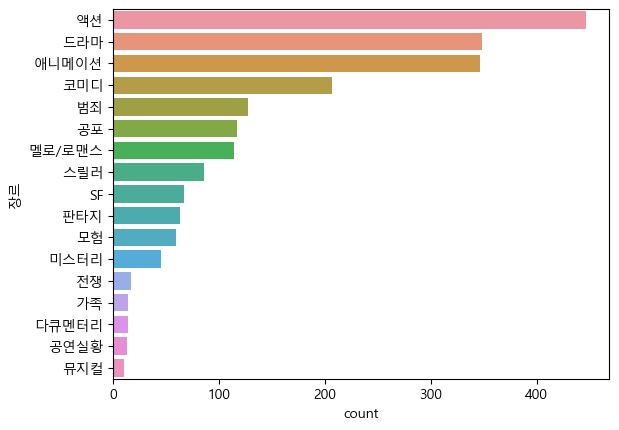

In [39]:
genreGraph = sns.barplot(data = genre, y = '장르', x = 'count')
genreGraph;

In [41]:
box_office = pd.read_excel("역대 박스 오피스 순위.xlsx")
box_office

,■ 역대 박스오피스 (공식통계 기준),Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10
0,- 조회일: 2023-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,- 출처: 영화진흥위원회 통합전산망 (http://www.kobis.or.kr),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,▶ 검색조건 [ 영화구분 : 일반영화 국적 : 전체 ],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,순위,영화명,개봉일,매출액,관객수,NaN,스크린수,NaN,대표국적,국적,배급사
4,NaN,NaN,NaN,NaN,(S:서울 기준),NaN,(S:서울 기준),NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
500,496,지.아이.조 2,2013-03-28 00:00:00,14457048500,NaN,1855917.0,NaN,766.0,미국,"미국,캐나다",(주)씨제이이엔엠
501,497,노무현입니다,2017-05-25 00:00:00,14554935612,NaN,1854867.0,NaN,775.0,한국,한국,"CGV아트하우스,영화사 풀"
502,498,집으로 가는 길,2013-12-11 00:00:00,13048519745,NaN,1854625.0,NaN,740.0,한국,한국,(주)씨제이이엔엠
503,499,악마를 보았다,2010-08-12 00:00:00,14148937025,NaN,1848418.0,NaN,494.0,한국,한국,(주)쇼박스


In [42]:
box_office = box_office.iloc[5:,1:]
box_office

,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10
5,명량,2014-07-30 00:00:00,135748398910,NaN,17613682.0,NaN,1587.0,한국,한국,(주)씨제이이엔엠
6,극한직업,2019-01-23 00:00:00,139647979516,NaN,16264944.0,NaN,1978.0,한국,한국,(주)씨제이이엔엠
7,신과함께-죄와 벌,2017-12-20 00:00:00,115698654137,NaN,14410754.0,NaN,1912.0,한국,한국,롯데쇼핑㈜롯데엔터테인먼트
8,국제시장,2014-12-17 00:00:00,110913469630,NaN,14257115.0,NaN,966.0,한국,한국,(주)씨제이이엔엠
9,어벤져스: 엔드게임,2019-04-24 00:00:00,122182694160,NaN,13934592.0,NaN,2835.0,미국,미국,월트디즈니컴퍼니코리아 유한책임회사
...,...,...,...,...,...,...,...,...,...,...
500,지.아이.조 2,2013-03-28 00:00:00,14457048500,NaN,1855917.0,NaN,766.0,미국,"미국,캐나다",(주)씨제이이엔엠
501,노무현입니다,2017-05-25 00:00:00,14554935612,NaN,1854867.0,NaN,775.0,한국,한국,"CGV아트하우스,영화사 풀"
502,집으로 가는 길,2013-12-11 00:00:00,13048519745,NaN,1854625.0,NaN,740.0,한국,한국,(주)씨제이이엔엠
503,악마를 보았다,2010-08-12 00:00:00,14148937025,NaN,1848418.0,NaN,494.0,한국,한국,(주)쇼박스


In [43]:
# 천만 관객 감독수

box_office[box_office['Unnamed: 5']>10000000.0]

,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10
5,명량,2014-07-30 00:00:00,135748398910,NaN,17613682.0,NaN,1587.0,한국,한국,(주)씨제이이엔엠
6,극한직업,2019-01-23 00:00:00,139647979516,NaN,16264944.0,NaN,1978.0,한국,한국,(주)씨제이이엔엠
7,신과함께-죄와 벌,2017-12-20 00:00:00,115698654137,NaN,14410754.0,NaN,1912.0,한국,한국,롯데쇼핑㈜롯데엔터테인먼트
8,국제시장,2014-12-17 00:00:00,110913469630,NaN,14257115.0,NaN,966.0,한국,한국,(주)씨제이이엔엠
9,어벤져스: 엔드게임,2019-04-24 00:00:00,122182694160,NaN,13934592.0,NaN,2835.0,미국,미국,월트디즈니컴퍼니코리아 유한책임회사
10,겨울왕국 2,2019-11-21 00:00:00,114810421450,NaN,13747792.0,NaN,2648.0,미국,미국,월트디즈니컴퍼니코리아 유한책임회사
11,아바타,2009-12-17 00:00:00,128447097523,NaN,13624328.0,NaN,912.0,미국,미국,"주식회사 해리슨앤컴퍼니,이십세기폭스코리아(주)"
12,베테랑,2015-08-05 00:00:00,105168155250,NaN,13414009.0,NaN,1064.0,한국,한국,(주)씨제이이엔엠
13,괴물,2006-07-27 00:00:00,0,NaN,13019740.0,S,167.0,한국,한국,(주)쇼박스
14,도둑들,2012-07-25 00:00:00,93665568500,NaN,12983330.0,NaN,1072.0,한국,"한국,홍콩",(주)쇼박스


In [44]:
director_1000 = box_office.loc[box_office['Unnamed: 5']>10000000.0]['Unnamed: 1'].tolist()
director_1000

['명량',
 '극한직업',
 '신과함께-죄와 벌',
 '국제시장',
 '어벤져스: 엔드게임',
 '겨울왕국 2',
 '아바타',
 '베테랑',
 '괴물',
 '도둑들',
 '7번방의 선물',
 '암살',
 '범죄도시2',
 '알라딘',
 '광해, 왕이 된 남자',
 '왕의 남자',
 '신과함께-인과 연',
 '택시운전사',
 '태극기 휘날리며',
 '부산행',
 '해운대',
 '변호인',
 '어벤져스: 인피니티 워',
 '실미도',
 '어벤져스: 에이지 오브 울트론',
 '기생충',
 '겨울왕국',
 '인터스텔라']

In [47]:
# 간단하게 크롤링 사용해서 영화 감독 검색하기

from tqdm import tqdm_notebook # 시간이 오래걸릴 수도 있으므로 얼마나 걸리는지 확인용
from bs4 import BeautifulSoup # 가져온 html 파싱용
from selenium import webdriver # 웹드라이버
from selenium.webdriver.common.by import By # 기능 동작 관련 함수

import time

In [48]:
# 웹 드랄이버 호출 및 url 적용
url = 'https://search.naver.com/search.naver?where=nexearch&sm=tab_etc&mra=bkEw&pkid=68&os=1756832&qvt=0&query=%EC%98%81%ED%99%94%20%ED%83%80%EC%9D%B4%ED%83%80%EB%8B%89%20%EC%B6%9C%EC%97%B0%EC%A7%84'

In [49]:
driver = webdriver.Chrome("../../Documents/ds_study/driver/chromedriver.exe")
driver.get(url)

In [50]:
director = []


for each_movie in tqdm_notebook(director_1000): 
    # 검색창 클릭하기
    element = driver.find_element(By.XPATH, '//*[@id="nx_query"]')
    element.clear()
    element.click()

    time.sleep(0.5)

    # 검색어 입력 후 엔터
    element.send_keys('영화 '+each_movie+' 출연진')
    element.submit()

    # 해당 페이지 파싱하기
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')

    director.append(soup.select('.name ._text')[0].text)
    time.sleep(0.5)

len(director)

  0%|          | 0/28 [00:00<?, ?it/s]

28

In [78]:
# bbc 선정 21세기 최고의 영화 100선
# 해당페이지 파싱하기
html = driver.page_source
soup = BeautifulSoup(html, 'html.parser')

# 영화목록 긁어오기
soup.select('a.DCLJQsNO')[2].text # '멀홀랜드 드라이브'
s1 =soup.select('a.DCLJQsNO')
bbc_movie = []
for i in range(2,104):
    bbc_movie.append(s1[i].text)
len(bbc_movie)

url = 'https://search.naver.com/search.naver?where=nexearch&sm=tab_etc&mra=bkEw&pkid=68&os=1756832&qvt=0&query=%EC%98%81%ED%99%94%20%ED%83%80%EC%9D%B4%ED%83%80%EB%8B%89%20%EC%B6%9C%EC%97%B0%EC%A7%84'
driver = webdriver.Chrome("../ds_study/driver/chromedriver.exe")
driver.get(url)

director_bbc = []
for each_movie in tqdm_notebook(bbc_movie):
    try :
        # 검색창 클릭하기
        element = driver.find_element(By.XPATH, '//*[@id="nx_query"]')
        element.clear()
        element.click()
        time.sleep(0.5)
    # 검색어 입력 후 엔터
        element.send_keys('영화 '+each_movie+' 출연진')
        element.submit()
    # 해당 페이지 파싱하기
        html = driver.page_source
        soup = BeautifulSoup(html, 'html.parser')
        director_bbc.append(soup.select('.name ._text')[0].text)
        time.sleep(0.5)
    except:
        director_bbc.append('error')
len(director_bbc)

  0%|          | 0/102 [00:00<?, ?it/s]

102

In [79]:
for i in  range(len(director_bbc)):
    if director_bbc[i] == 'error':
        print(i, bbc_movie[i])

8 씨민과 나데르의 별거
16 판의 미로
62 토리노의 말
88 머리 없는 여인


In [80]:
director_bbc[8] = '아스가르 파르하디'
director_bbc[16] = '기예르모 델 토로'
director_bbc[62] = '벨라 타르'
director_bbc[88] = '루크레시아 마르텔'
for i in  range(len(director_bbc)):
    if director_bbc[i] == 'error':
        print(i, bbc_movie[i])

In [81]:
for i in  range(len(director_bbc)):
    if director_bbc[i] == 'error':
        print(i, bbc_movie[i])

In [82]:
# 천만 관객 + BBC

director_add = director + director_bbc
len(director_add)

130

In [83]:
# 공백 제거

for i in range(len(director_add)):
    director_add[i] = director_add[i].replace(' ','')
    

director_add

['김한민',
 '이병헌',
 '김용화',
 '윤제균',
 '안소니루소',
 '크리스벅',
 '제임스카메론',
 '류승완',
 '봉준호',
 '최동훈',
 '이환경',
 '최동훈',
 '이상용',
 '존머스커',
 '추창민',
 '이준익',
 '김용화',
 '장훈',
 '강제규',
 '연상호',
 '윤제균',
 '양우석',
 '안소니루소',
 '강우석',
 '조스웨던',
 '봉준호',
 '크리스벅',
 '크리스토퍼놀란',
 '데이빗린치',
 '왕가위',
 '폴토마스앤더슨',
 '미야자키하야오',
 '리처드링클레이터',
 '미셸공드리',
 '테렌스맬릭',
 '에드워드양',
 '아스가르파르하디',
 '에단코엔',
 '조엘코엔',
 '데이빗핀처',
 '알폰소쿠아론',
 '조슈아오펜하이머',
 '크리스티안문쥬',
 '레오카락스',
 '기예르모델토로',
 '미카엘하네케',
 '조지밀러',
 '찰리카프먼',
 '웨스앤더슨',
 '소피아코폴라',
 '미카엘하네케',
 '조의석',
 '크리스토퍼놀란',
 '스파이크리',
 '데이빗핀처',
 '페드로알모도바르',
 '앤드류스탠튼',
 '박찬욱',
 '케네스로너건',
 '노도현',
 '크리스토퍼놀란',
 '라즐로네메스',
 '이안',
 '자크투르뇌르',
 '아피찻퐁위라세타쿤',
 '페르난도메이렐레스',
 '테렌스맬릭',
 '이안',
 '피트닥터',
 '장-미쉘벵수산',
 '라스폰트리에',
 '스티브맥퀸',
 '압델라티프케시시',
 '압바스키아로스타미',
 '강범철',
 '존크로울리',
 '장뤽고다르',
 '허우샤오시엔',
 '크리스토퍼놀란',
 '아핏차퐁위라세타쿤',
 '바즈루어만',
 '누리빌게제일란',
 '파벨포리코브스키',
 '벨라타르',
 '캐스린비글로우',
 '우스만셈벤',
 '데이빗크로넨버그',
 '아핏차퐁위라세타쿤',
 '조나단글레이저',
 '쿠엔틴타란티노',
 '벨라타르',
 '파올로소렌티노',
 '리우하오지',
 '김기덕',
 '캐서린비글로우',
 '웨스앤더슨',
 '토드헤인즈',
 '사라폴리',
 '고구마',


In [84]:
len(director_add)

130

In [85]:
# 감독 인코딩

le_list = []
for i in movieData['감독']:
    if i in director_add:
        le_list.append(1.)
    else:
        le_list.append(0.)

len(le_list)

2093

In [86]:
movieData['le_감독'] = le_list
movieData

,영화명,개봉일,매출액,관객수,스크린수,상영횟수,대표국적,국적,배급사,연령등급,장르,러닝타임,감독,개봉월,계절,le_감독
0,800,2020-12-10,135367500,15549,223,3738,중국,중국,TCO(주)더콘텐츠온,15세 관람가,전쟁,149,관후,12,겨울,0.0
1,1917,2020-02-19,7924722960,877017,932,91511,미국,미국,(주)스마일이엔티,15세 관람가,드라마,119,샘 멘데스,2,겨울,0.0
2,1987,2017-12-27,58169776145,1942077,1299,27619,한국,한국,(주)씨제이이엔엠,15세 관람가,드라마,129,장준환,12,겨울,0.0
3,#살아있다,2020-06-24,15968219900,1903992,1882,137073,한국,한국,롯데컬처웍스(주)롯데엔터테인먼트,15세 관람가,드라마,98,조일형,6,여름,0.0
4,0.0MHz,2019-05-29,1088258860,137294,446,5998,한국,한국,(주)스마일이엔티,15세 관람가,공포,102,유선동,5,봄,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2088,히트,2011-10-13,783919500,110631,171,5960,한국,한국,(주)넥스트엔터테인먼트월드(NEW),청소년 관람불가,범죄,170,마이클 만,10,가을,0.0
2089,히트맨,2007-11-29,1094879000,163414,155,10301,미국,미국,이십세기폭스필름코퍼레이션,청소년 관람불가,액션,92,자비에르 젠스,11,가을,0.0
2090,히트맨,2020-01-22,20614278000,2406232,1122,87782,한국,한국,롯데컬처웍스(주)롯데엔터테인먼트,15세 관람가,코미디,110,최원섭,1,겨울,0.0
2091,히트맨: 에이전트 47,2015-09-03,502308500,64157,272,4501,미국,미국,이십세기폭스코리아(주),15세 관람가,액션,98,알렉산더 바흐,9,가을,0.0


In [87]:
movieData['le_감독'].value_counts()

0.0    2019
1.0      74
Name: le_감독, dtype: int64

In [95]:
# movieData 저장

movieData.to_excel('movieData.xlsx', index=False)

## 감독 참여작 수

In [88]:
director = pd.read_excel('감독_참여작수.xlsx')
director

,영화명,감독,참여작수
0,800,관후,1
1,1917,샘 멘데스,20
2,1987,장준환,14
3,#살아있다,조일형,1
4,0.0MHz,유선동,6
...,...,...,...
2088,히트,마이클 만,23
2089,히트맨,자비에르 젠스,15
2090,히트맨,최원섭,6
2091,히트맨: 에이전트 47,알렉산더 바흐,2


In [89]:
director.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2093 entries, 0 to 2092
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   영화명     2093 non-null   object
 1   감독      2093 non-null   object
 2   참여작수    2093 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 49.2+ KB


In [91]:
movieData['참여작수'] = director['참여작수']

movieData

,영화명,개봉일,매출액,관객수,스크린수,상영횟수,대표국적,국적,배급사,연령등급,장르,러닝타임,감독,개봉월,계절,le_감독,참여작수
0,800,2020-12-10,135367500,15549,223,3738,중국,중국,TCO(주)더콘텐츠온,15세 관람가,전쟁,149,관후,12,겨울,0.0,1
1,1917,2020-02-19,7924722960,877017,932,91511,미국,미국,(주)스마일이엔티,15세 관람가,드라마,119,샘 멘데스,2,겨울,0.0,20
2,1987,2017-12-27,58169776145,1942077,1299,27619,한국,한국,(주)씨제이이엔엠,15세 관람가,드라마,129,장준환,12,겨울,0.0,14
3,#살아있다,2020-06-24,15968219900,1903992,1882,137073,한국,한국,롯데컬처웍스(주)롯데엔터테인먼트,15세 관람가,드라마,98,조일형,6,여름,0.0,1
4,0.0MHz,2019-05-29,1088258860,137294,446,5998,한국,한국,(주)스마일이엔티,15세 관람가,공포,102,유선동,5,봄,0.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2088,히트,2011-10-13,783919500,110631,171,5960,한국,한국,(주)넥스트엔터테인먼트월드(NEW),청소년 관람불가,범죄,170,마이클 만,10,가을,0.0,23
2089,히트맨,2007-11-29,1094879000,163414,155,10301,미국,미국,이십세기폭스필름코퍼레이션,청소년 관람불가,액션,92,자비에르 젠스,11,가을,0.0,15
2090,히트맨,2020-01-22,20614278000,2406232,1122,87782,한국,한국,롯데컬처웍스(주)롯데엔터테인먼트,15세 관람가,코미디,110,최원섭,1,겨울,0.0,6
2091,히트맨: 에이전트 47,2015-09-03,502308500,64157,272,4501,미국,미국,이십세기폭스코리아(주),15세 관람가,액션,98,알렉산더 바흐,9,가을,0.0,2


In [96]:
# movieData 저장

movieData.to_excel('df4.xlsx', index=False)

In [99]:
movieDataTest = pd.read_excel('df4.xlsx')
movieDataTest

,영화명,개봉일,매출액,관객수,스크린수,상영횟수,대표국적,국적,배급사,연령등급,장르,러닝타임,감독,개봉월,계절,le_감독,참여작수
0,800,2020-12-10,135367500,15549,223,3738,중국,중국,TCO(주)더콘텐츠온,15세 관람가,전쟁,149,관후,12,겨울,0,1
1,1917,2020-02-19,7924722960,877017,932,91511,미국,미국,(주)스마일이엔티,15세 관람가,드라마,119,샘 멘데스,2,겨울,0,20
2,1987,2017-12-27,58169776145,1942077,1299,27619,한국,한국,(주)씨제이이엔엠,15세 관람가,드라마,129,장준환,12,겨울,0,14
3,#살아있다,2020-06-24,15968219900,1903992,1882,137073,한국,한국,롯데컬처웍스(주)롯데엔터테인먼트,15세 관람가,드라마,98,조일형,6,여름,0,1
4,0.0MHz,2019-05-29,1088258860,137294,446,5998,한국,한국,(주)스마일이엔티,15세 관람가,공포,102,유선동,5,봄,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2088,히트,2011-10-13,783919500,110631,171,5960,한국,한국,(주)넥스트엔터테인먼트월드(NEW),청소년 관람불가,범죄,170,마이클 만,10,가을,0,23
2089,히트맨,2007-11-29,1094879000,163414,155,10301,미국,미국,이십세기폭스필름코퍼레이션,청소년 관람불가,액션,92,자비에르 젠스,11,가을,0,15
2090,히트맨,2020-01-22,20614278000,2406232,1122,87782,한국,한국,롯데컬처웍스(주)롯데엔터테인먼트,15세 관람가,코미디,110,최원섭,1,겨울,0,6
2091,히트맨: 에이전트 47,2015-09-03,502308500,64157,272,4501,미국,미국,이십세기폭스코리아(주),15세 관람가,액션,98,알렉산더 바흐,9,가을,0,2


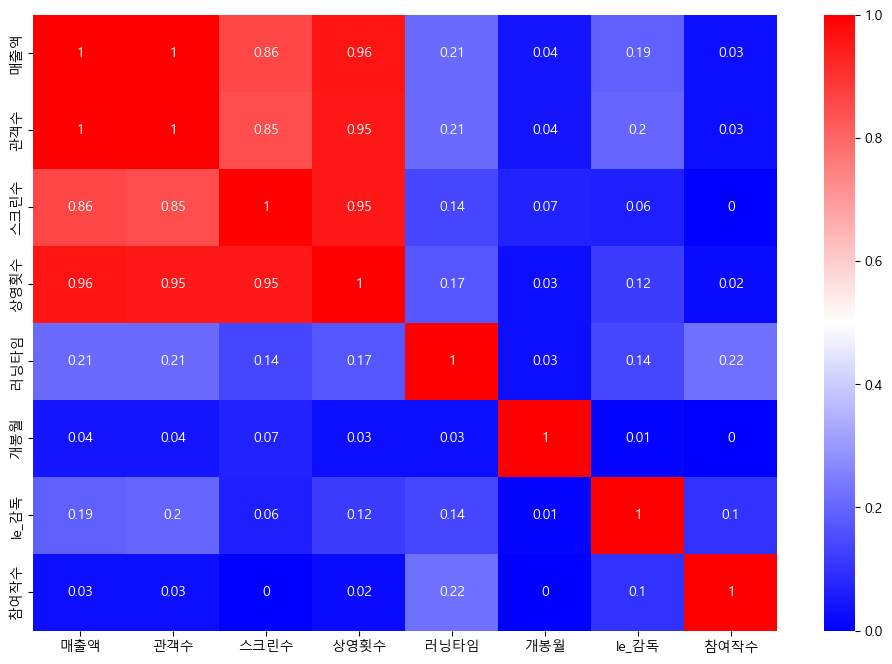

In [101]:
plt.figure(figsize=(12,8))
corr_mat = movieData.corr().round(2)
sns.heatmap(data=corr_mat, annot=True, cmap='bwr');

<AxesSubplot:>

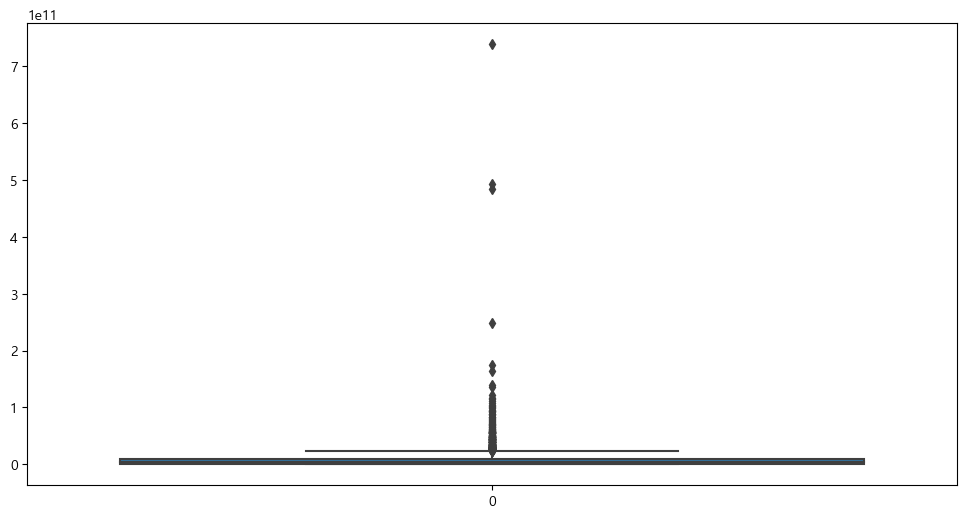

In [102]:
plt.figure(figsize=(12,6))
sns.boxplot(data = movieData['매출액'])

In [103]:
q1 = np.percentile(movieData['매출액'], 25)  
q2 = np.median(movieData['매출액'])
q3 = np.percentile(movieData['매출액'], 75)

q1,q2,q3
iqr = q3 - q1

iqr
upper_fence = q3 + iqr*1.5
lower_fence = q1 - iqr*1.5

upper_fence,lower_fence
movieData[movieData['매출액'] > upper_fence].index
for i in movieData[movieData['매출액'] > upper_fence].index:
    movieData.drop(axis=0, index=i, inplace=True)

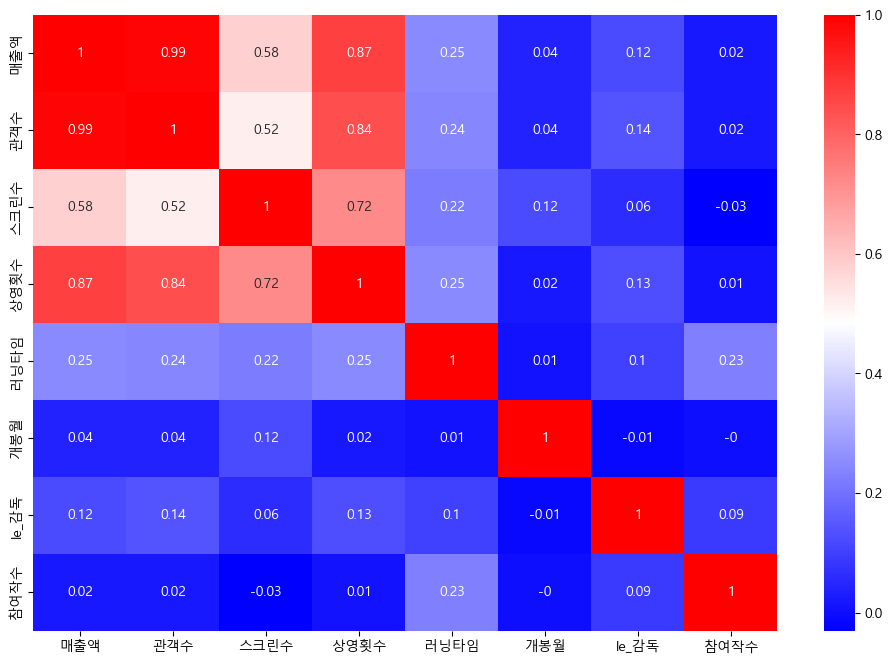

In [104]:
plt.figure(figsize=(12,8))
corr_mat = movieData.corr().round(2)
sns.heatmap(data=corr_mat, annot=True, cmap='bwr');